### ANRP (Automatic Number Plate Recognition)


#### Biblioteca Usadas:
* [Numpy](https://numpy.org/doc/) - Para calculos matriciais usando Python
* [ImgUtils](https://github.com/dimatura/imgutils) - Compilado de Libs para manipulação de imagem em Python
* [Open CV](https://docs.opencv.org/4.x/d6/d00/tutorial_py_root.html) - Pré Processamento das Imagens e Edge Detection
* [PyTorch](https://pytorch.org/get-started/locally/) - Para facilitar o uso Easy OCR
* [Easy OCR](https://github.com/JaidedAI/EasyOCR) - Extração de Texto de Imagens - OCR (Optical Character Recognition)

Referêrencias:
* [Licence Place Recognition using Raspberry Pi and OpenCV](https://circuitdigest.com/microcontroller-projects/license-plate-recognition-using-raspberry-pi-and-opencv)
* [Licence Place Recognition using EasyOCR and PyTorch](https://github.com/nicknochnack/ANPRwithPython)

In [3]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr

##### 1. Lendo a imagem, e convertendo para escala de cinza:

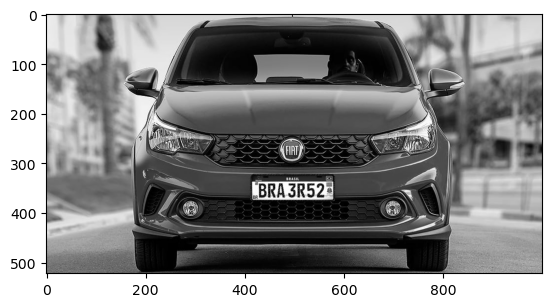

In [183]:
#Lendo a imagem e armazenando na variável "img"
img = cv2.imread(r'assets/brasil/image1.jpg')

#Convertendo a imagem para de (BGR - Blue Green Red) para Gray (Tom de Cinza)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#Como o MatplotLib espera a imagem em RGB precisamos dizer que originalmente era em BGR
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

##### 2. Aplicando Filtros e marcando as bordas das imagens:
A ideia de aplicar filtros é para remover ruídos da imagem, melhorando a qualidade para que facilite a identificação de contornos.

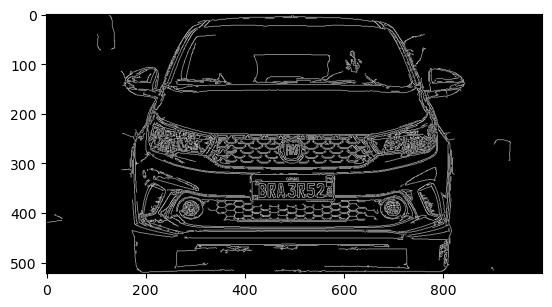

In [184]:
#Redução de Ruído usando um método de filtro bilateral (os parametros podem ser tunados e representam intensidade da redução de ruído e suavidez):
bfilter = cv2.bilateralFilter(gray, 11, 17, 17)

#Detecção de contornos (parametros podem ser tunados):
edged=cv2.Canny(bfilter, 30, 200)

#Plotando a imagem:
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

##### 3. Encontrando contotrnos e aplicando mascára de camada:

In [185]:
#Função que percorre a imagem em busca de contornos:
keypoints = cv2.findContours(edged.copy(),  #Copia da nossa imagem com detercção de bordas
                            cv2.RETR_TREE,  #Argumento que define que retornaremos o resultado em forma de uma árvore
                            cv2.CHAIN_APPROX_SIMPLE) #Receberemos uma versão simplificada dos contornos, uma aproximação do contorno

#Guardamos o contorno dos keypoints:
contours = imutils.grab_contours(keypoints)

#Pegando somente os contornos com maior confiabilidade:
contours=sorted(contours,
                key=cv2.contourArea,
                reverse=True)[:10]

In [186]:
location = None

#Para cada contorno, buscaremos os que possuem 4 pontos (retangulo):
for contour in contours:
    approx = cv2.approxPolyDP(contour, 8, True) #Permite aproximar os contornos para encontrar o retangulo (o parametro numerico quanto maior, mais forçada será a aproximação)
    if len(approx) == 4:
        location = approx
        break

In [187]:
location

array([[[415, 339]],

       [[577, 337]],

       [[579, 371]],

       [[417, 374]]], dtype=int32)

In [188]:
#Aplicando uma máscara de camada na imagem para manter somente a área de interesse:
mask =np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0, 255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)

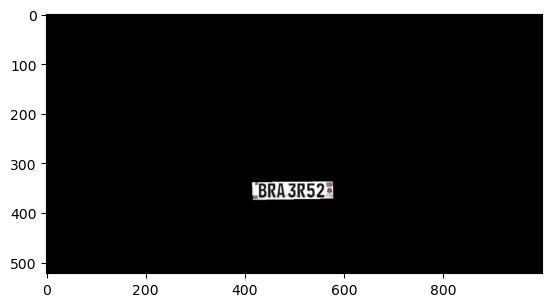

In [189]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [190]:
#Limpando a imagem onde tem mascara, mantendo somente a placa:

#Encontrando toda a parcela da imagem onde não está mascarado:
(x,y) = np.where(mask==255)

#Criando os pontos de coordenadas:
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))

#Criando a nova imagem:
croppedImage=gray[x1:x2, y1:y2]

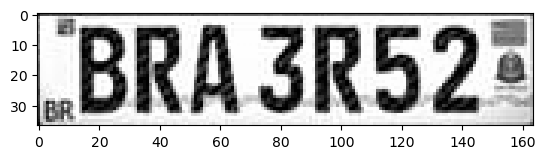

In [191]:
plt.imshow(cv2.cvtColor(croppedImage, cv2.COLOR_BGR2RGB))

##### 4. Usando Easy OCR para ler o texto:

In [192]:
#Criando uma instancia do Leitor (Reader) e setando para caracteres latinos PT:
reader = easyocr.Reader(['pt'])

#Lendo o texto e armazenando em result:
result = reader.readtext(croppedImage)

#Mostrando os resultados:
result

[([[7, 0], [153, 0], [153, 37], [7, 37]], 'BRA 3R52', 0.905077198848664)]

In [193]:
print(f'Os caracteres da placa são: {result[0][1]}')
print(f'A confiabilidade do resultado é: {result[0][2]}')

Os caracteres da placa são: BRA 3R52
A confiabilidade do resultado é: 0.905077198848664


##### 5. Renderizando o Resultado:

In [194]:
#pegando o texto lido da imagem:
text = result[0][-2]

#Especifacando a fonte a ser usada:
font = cv2.FONT_HERSHEY_SIMPLEX

#Criando a variável resultado, combiando o texto com a imagem:
res = cv2.putText(img,
                text=text,
                org=(approx[0][0][0], approx[1][0][1]+70), #Local onde o texto será plotado
                fontFace=font,
                fontScale=1,
                color=(255,255,0),
                thickness=2,
                lineType=cv2.LINE_AA)

#Adicionando o desenho do retangulo em volta da placa:
res = cv2.rectangle(img,
                    tuple(approx[0][0]),
                    tuple(approx[2][0]),
                    (255,255,0),
                    3)


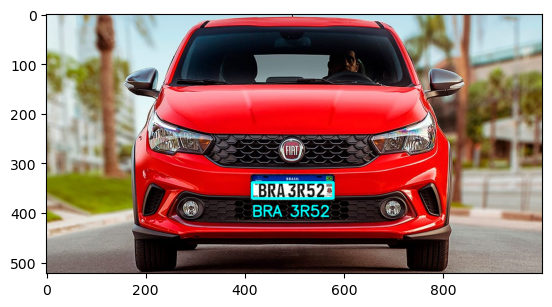

In [195]:
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))